In [4]:
import os
import cv2
import torch
import logging
import tempfile
import librosa
import numpy as np
import torchvision.transforms as transforms
from torchvision import models
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
from tqdm import tqdm
import ollama

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

c:\Users\prana\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [5]:
VIDEO_PATH = r"C:\Users\prana\Downloads\Research DL\Vid\skyAeroplaneTest.mp4"
LABELS_PATH = r"C:\Users\prana\Downloads\Research DL\Vid\imagenet_classes.txt"

In [6]:
OLLAMA_MODEL = "granite3-dense:2b"

In [9]:
class VideoAnalyzer:
    def __init__(self):
        # Initialize models
        self.image_caption_model = self._load_image_caption_model()
        self.asr_model = self._load_asr_model()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.eval()
        
        # Image transforms
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _load_image_caption_model(self):
        """Load BLIP model for image captioning."""
        processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        return processor, model

    def _load_asr_model(self):
        """Load automatic speech recognition model."""
        processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
        return processor, model

    def extract_frames(self, video_path, frame_interval=30):
        """Extract frames from video at fixed interval."""
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        with tqdm(total=total_frames, desc="Extracting Frames") as pbar:
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                if frame_count % frame_interval == 0:
                    image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    frames.append(image)
                
                frame_count += 1
                pbar.update(1)

        cap.release()
        logging.info(f"Extracted {len(frames)} frames from video.")
        return frames

    def generate_caption(self, image):
        """Generate a natural language caption for an image using BLIP."""
        processor, model = self.image_caption_model
        inputs = processor(image, return_tensors="pt")
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption

    def extract_and_transcribe_audio(self, video_path):
        """Extract audio from video and transcribe using Wav2Vec2."""
        try:
            with tempfile.TemporaryDirectory() as temp_dir:
                temp_audio_path = os.path.join(temp_dir, "temp_audio.wav")
                os.system(f'ffmpeg -i "{video_path}" -q:a 0 -map a "{temp_audio_path}" -loglevel error -y')
                
                processor, model = self.asr_model
                audio, rate = librosa.load(temp_audio_path, sr=16000)
                input_values = processor(audio, return_tensors="pt", sampling_rate=16000).input_values
                
                with torch.no_grad():
                    logits = model(input_values).logits
                
                predicted_ids = torch.argmax(logits, dim=-1)
                transcription = processor.batch_decode(predicted_ids)[0]
                return transcription
        except Exception as e:
            logging.error(f"Error processing audio: {e}")
            return ""

    def query_granite_model(self, prompt):
        """Query Granite-3-Dense-2B using local Ollama framework."""
        try:
            response = ollama.generate(model=OLLAMA_MODEL, prompt=prompt)
            return response['response'] if 'response' in response else ""
        except Exception as e:
            logging.error(f"Error querying Granite model: {e}")
            return ""

    def generate_multimodal_summary(self, video_path):
        """Generate a comprehensive summary using Granite-3-Dense-2B."""
        print("\nProcessing video, please wait...")
        
        # Extract and analyze video frames
        frames = self.extract_frames(video_path)
        captions = []
        for frame in tqdm(frames, desc="Generating Captions"):
            captions.append(self.generate_caption(frame))
        unique_captions = list(set(captions))
        
        # Transcribe audio
        transcription = self.extract_and_transcribe_audio(video_path)
        
        # Prepare prompt for Granite-3-Dense-2B
        prompt = f"""
        **Video Content Analysis:**
        {', '.join(unique_captions)}

        **Audio Transcript:**
        {transcription if transcription else "No speech detected."}

        **Task:**
        Generate a professional, coherent summary that combines the visual and audio elements.
        Focus on creating a narrative that flows naturally while accurately representing both modalities.
        Maintain a neutral, informative tone suitable for professional documentation.
        """
        
        print("\nQuerying local Granite model for summary...")
        summary = self.query_granite_model(prompt)
        return summary.strip()

In [10]:
def main():
    analyzer = VideoAnalyzer()
    summary = analyzer.generate_multimodal_summary(VIDEO_PATH)
    
    print("\n" + "=" * 80)
    print("MULTIMODAL VIDEO SUMMARY (Generated by Granite-3-Dense-2B)".center(80))
    print("=" * 80)
    print(summary)
    print("=" * 80)

if __name__ == "__main__":
    main()

c:\Users\prana\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSeq


Processing video, please wait...


Extracting Frames: 100%|██████████| 637/637 [00:10<00:00, 58.51it/s]
2025-04-09 13:00:50,412 - INFO - Extracted 22 frames from video.
Generating Captions:   0%|          | 0/22 [00:00<?, ?it/s]c:\Users\prana\anaconda3\Lib\site-packages\transformers\generation\utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Generating Captions: 100%|██████████| 22/22 [01:11<00:00,  3.23s/it]



Querying local Granite model for summary...


2025-04-09 13:02:36,268 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"



           MULTIMODAL VIDEO SUMMARY (Generated by Granite-3-Dense-2B)           
The video captures a serene scene of nature and human-made technology in harmony. A bird is gracefully soaring through the sky, its wings fluttering rhythmically against the backdrop of a clear blue sky. In contrast, a plane is visible in the distance, its metallic body glinting under the sun as it traverses the skies with precision and speed. Despite the absence of audio in this segment, the visual narrative suggests a harmonious coexistence of natural flight and artificial aviation.


![Screenshot 2025-04-20 151655.png](<attachment:Screenshot 2025-04-20 151655.png>)
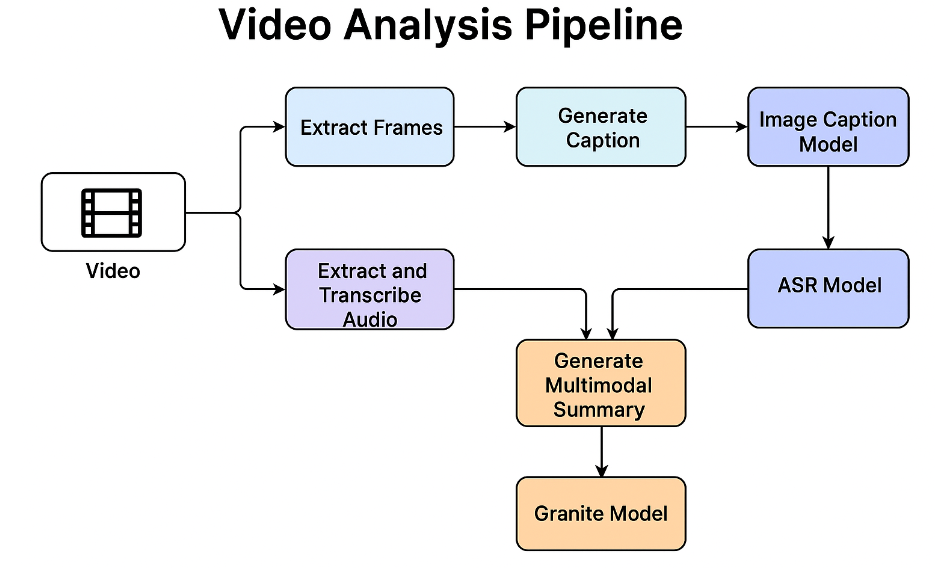

MULTIMODAL VIDEO SUMMARY (Generated by Granite-3-Dense-2B)           

The video content analysis reveals a series of images that depict various financial scenarios. The backgrounds include a black crumpled paper, a Greek temple, and a building with a bank sign. People are shown carrying money, sitting on buildings, and walking towards banks. A man in a suit is seen walking towards a white building, while another man in a turban is standing on a building with a scale. The audio transcript focuses on the concept of banks using deposits to generate profit rather than holding onto cash. The speaker emphasizes that when you deposit money at a bank, it becomes a liability for the bank, which aims to lend it out as an investment instead of keeping it in cash. This process results in the value of your money decreasing each day. In summary, the video and audio content highlight the relationship between banks and deposits, with banks using deposits to generate income by lending them out, while the value of the deposited money decreases over time.

MULTIMODAL VIDEO SUMMARY (Generated by Granite-3-Dense-2B)

The video captures a serene aerial scene, featuring a bird gracefully soaring through the sky. In contrast, a plane is also visible, moving steadily against the backdrop of the birdd's flight. Despite the absence of spoken words in the audio transcript, the tranquility of the scene is palpable, underscored by the silent symphony of nature and machinery in motion.